# Milestone3

# TASK1

#### To understand the distribution of conspiracy theories across YouTube, we first analyzed the proportion of videos containing conspiracy-related terms within different content categories. This analysis reveals that while conspiracy narratives appear across a range of categories, they are particularly concentrated in the News & Politics space. Such findings underscore the close association between conspiracy content and political discourse, though other categories like Entertainment and People & Blogs also show notable presence.

#### As shown in the figure below, these results highlight the varied but uneven spread of conspiracy theories across YouTube's content ecosystem.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import numpy as np
from scipy import stats
import re
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [9]:
# Load the data, and print the first few rows to see what it looks like
data = pd.read_json('./yt_metadata_filtered_"trump ".jsonl', lines=True)

keywords = ['QAnon', 'Deep State', 'deepstate', "Election Fraud", "Missing Emails", "Biden Family Scandal", "Climate Change Hoax"]  # List of keywords corresponding to conspiracy theories

# Create a mask that selects rows where the title, description, or tags contain any of the keywords
mask_title = data['title'].str.contains('|'.join(keywords), case=False, na=False)
mask_description = data['description'].str.contains('|'.join(keywords), case=False, na=False)
mask_tags = data['tags'].str.contains('|'.join(keywords), case=False, na=False)

# Apply the mask to the data
filtered_data = data[mask_title | mask_description | mask_tags]

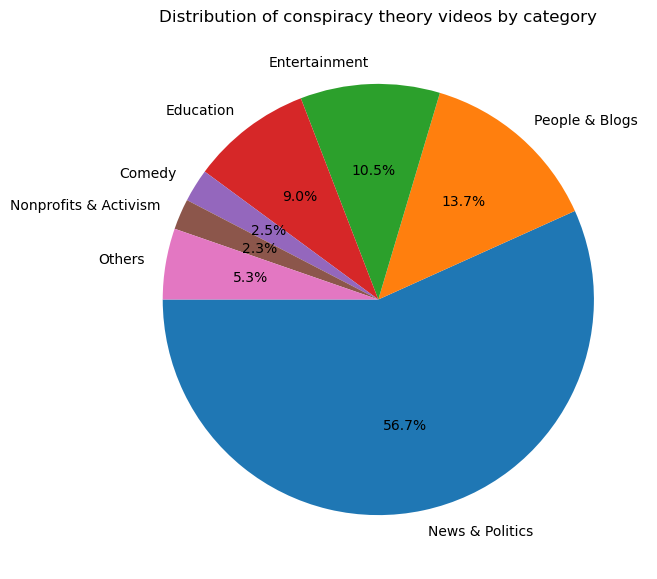

In [10]:
# Count the number of videos in each category
category_counts = filtered_data.drop_duplicates(subset='channel_id')['categories'].value_counts()

# Plot the distribution of conspiracy theory videos by category
threshold = 0.02  # 2% threshold
other_count = category_counts[category_counts / category_counts.sum() < threshold].sum()
main_categories = category_counts[category_counts / category_counts.sum() >= threshold]
main_categories['Others'] = other_count

plt.figure(figsize=(10, 7))
main_categories.plot(kind='pie', autopct='%1.1f%%', startangle=180)
plt.title('Distribution of conspiracy theory videos by category')
plt.ylabel('')
plt.show()

# TASK2

In [ ]:
import pandas as pd
import json

df_channels = pd.read_csv('df_channels_en.tsv', sep='\t')


In [ ]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

df_metadata = load_jsonl('metadata_filtered.jsonl')

df_metadata.rename(columns={'channel_id': 'channel'}, inplace=True)

In [ ]:
df_channels.dropna(subset=['channel'], inplace=True)
df_metadata.fillna({'description': '', 'tags': '', 'keywords': ''}, inplace=True)


# remove duplicates
df_channels.drop_duplicates(subset=['channel'], inplace=True)
df_metadata.drop_duplicates(subset=['display_id'], inplace=True)

df_channels['channel'] = df_channels['channel'].str.upper()
df_metadata['channel'] = df_metadata['channel'].str.upper()


# merge statistics with metadata
df_combined = pd.merge(df_metadata, df_channels, left_on='channel', right_on='channel', how='left')


In [ ]:
print(df_combined.columns)

Index(['categories', 'channel', 'crawl_date', 'description', 'dislike_count',
       'display_id', 'duration', 'like_count', 'tags', 'title', 'upload_date',
       'view_count', 'keywords', 'category_cc', 'join_date', 'name_cc',
       'subscribers_cc', 'videos_cc', 'subscriber_rank_sb', 'weights'],
      dtype='object')


In [ ]:
import re

# define a function to extract keywords from the description
conspiracy_definitions = {
    "conspiracy_theories": [
        {
            "name": "Deep State",
            "description": "Refers to a hidden powerful faction within the government allegedly working to undermine Trump and his supporters."
        },
        {
            "name": "Election Fraud",
            "description": "Claims of widespread election fraud, especially in the 2020 presidential election, focusing on alleged issues with mail-in ballots."
        },
        {
            "name": "QAnon",
            "description": "While not explicitly endorsed, Trump has shown indirect support for followers of QAnon, a conspiracy about a deep-rooted cabal involved in child trafficking and satanic rituals."
        },
        {
            "name": "Missing Emails",
            "description": "Refers to the 2016 scandal involving Hillary Clinton’s deleted emails, which Trump frequently highlighted."
        },
        {
            "name": "Biden Family Scandal",
            "description": "Claims of corruption within the Biden family, particularly involving Hunter Biden’s business dealings and alleged exploitation of Biden’s influence."
        },
        {
            "name": "Climate Change Hoax",
            "description": "Skepticism toward climate change, suggesting it's a 'hoax' promoted by global elites for profit."
        }
    ]
}

# print the conspiracy definitions
conspiracy_keywords = {
    "Deep State": ["deepstate", "deep state", "government faction", "shadow government", "hidden government"],
    "Election Fraud": ["election fraud", "vote fraud", "mail-in ballots", "voter suppression", "rigged election"],
    "QAnon": ["qanon", "cabal", "child trafficking", "satanic rituals", "deep-rooted cabal", "Q movement"],
    "Missing Emails": ["missing emails", "deleted emails", "clinton emails", "email scandal", "email leak"],
    "Biden Family Scandal": ["biden family scandal", "hunter biden", "biden corruption", "biden business dealings", "biden influence"],
    "Climate Change Hoax": ["climate change hoax", "global elites", "climate profit", "false climate", "climate deception"]
}


In [ ]:

# check if a text contains any of the conspiracy
def detect_conspiracy_types(row, keywords_dict):
    # combine the title, description, and tags into a single text
    text = ' '.join([str(row['title']), str(row['description']), str(row['tags'])]).lower()
    detected = {}
    for theory, keywords in keywords_dict.items():
        # create a regular expression pattern to match any of the keywords
        pattern = re.compile('|'.join([re.escape(word) for word in keywords]), re.IGNORECASE)
        if pattern.search(text):
            detected[theory] = 1
            continue
        else:
            detected[theory] = 0
    return pd.Series(detected)


In [ ]:
# Initialize list to store records with conspiracy keywords
df_combined = df_combined.fillna({'title': '', 'description': '', 'tags': '', 'keywords': ''})

conspiracy_detection = df_combined.apply(lambda row: detect_conspiracy_types(row, conspiracy_keywords), axis=1)
df_combined_with_conspiracy = pd.concat([df_combined, conspiracy_detection], axis=1)

# add a column to indicate if any conspiracy keyword was detected
df_combined_with_conspiracy['is_conspiracy'] = df_combined_with_conspiracy[list(conspiracy_keywords.keys())].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Remove zero or negative values to avoid issues with the logarithmic scale
view_counts = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['view_count']
view_counts = view_counts[view_counts > 0]


# Like/Dislike ratio distribution for conspiracy videos
# Avoid division by zero by replacing 0 dislikes with a small number (or filtering them out)
like_count = df_combined_with_conspiracy['like_count']
dislike_count = df_combined_with_conspiracy['dislike_count']
dislike_count = dislike_count.replace(0, np.nan)  # Replace 0 dislikes with NaN to avoid division issues

# Calculate ratio, dropping NaNs (resulting from zero dislikes)
df_combined_with_conspiracy['like_dislike_ratio'] = like_count / dislike_count
ratio_data = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['like_dislike_ratio'].dropna()


In [ ]:
# get non-conspiracy records

pd.set_option('display.float_format', '{:,.2f}'.format)
# # Display the first few rows of the DataFrame

non_conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 0]


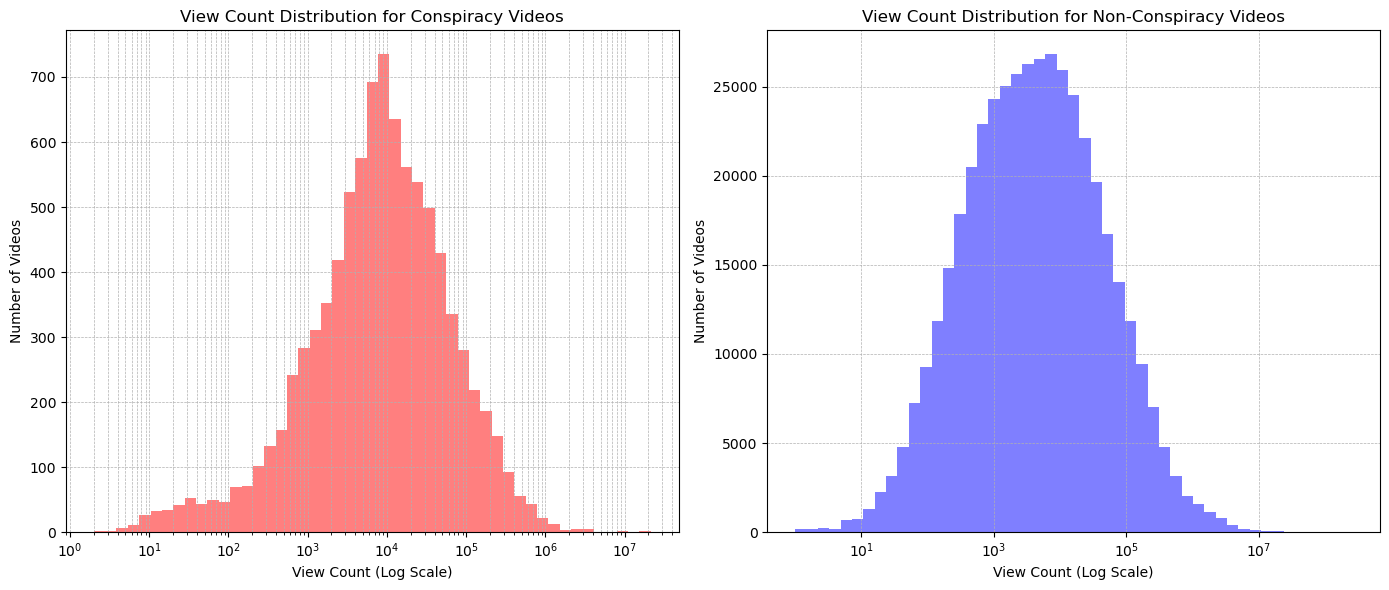

<Figure size 1400x1200 with 0 Axes>

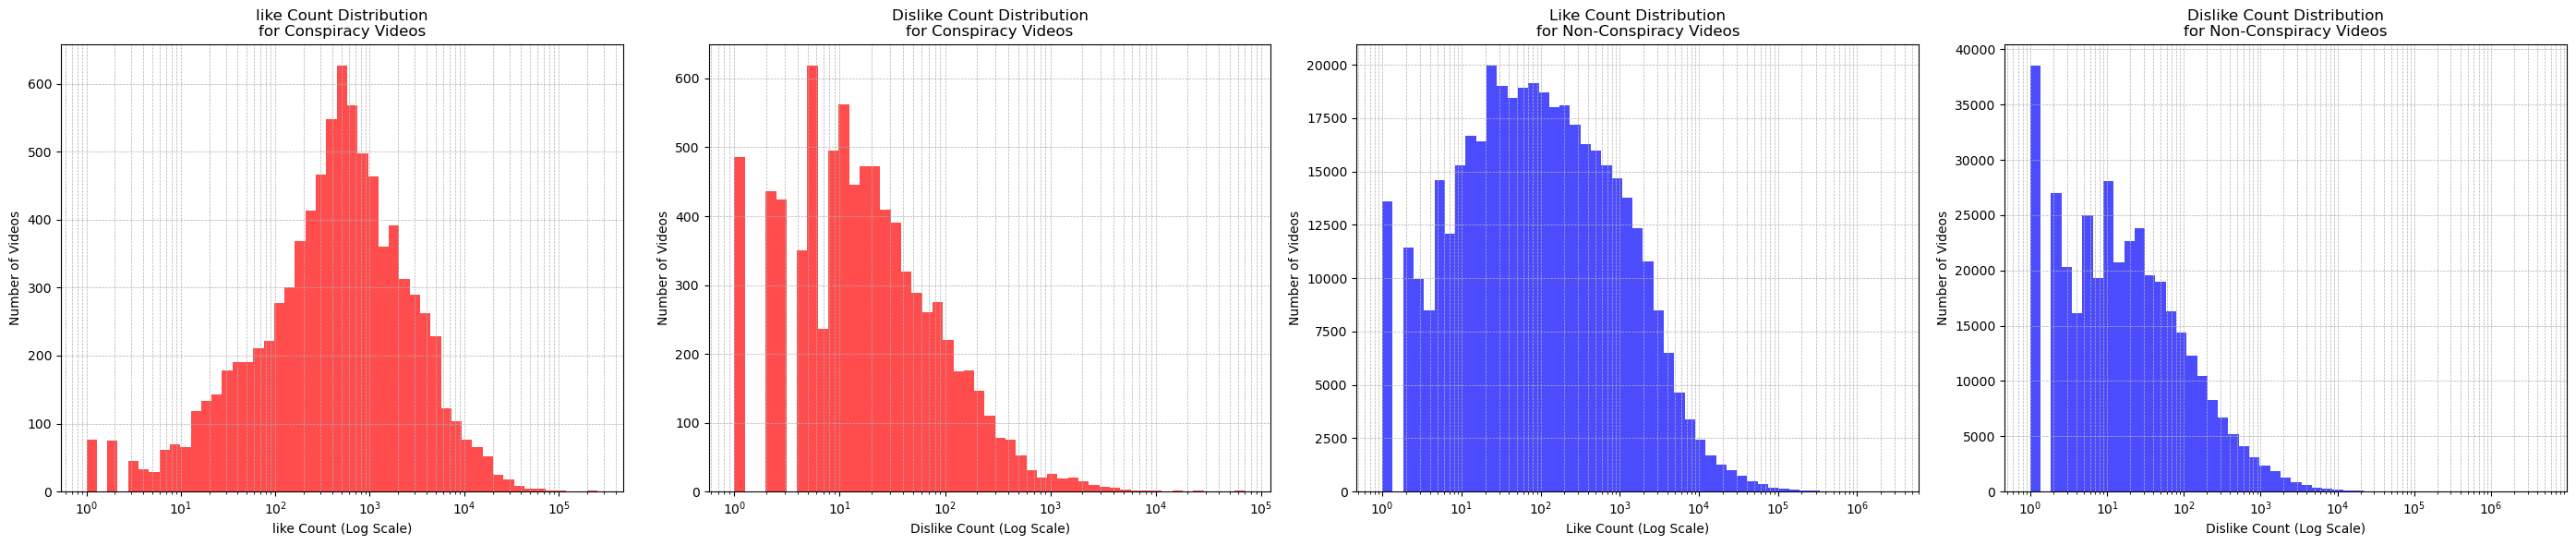

/tmp/ipykernel_4101123/3622748967.py:147: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4101123/3622748967.py:160: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



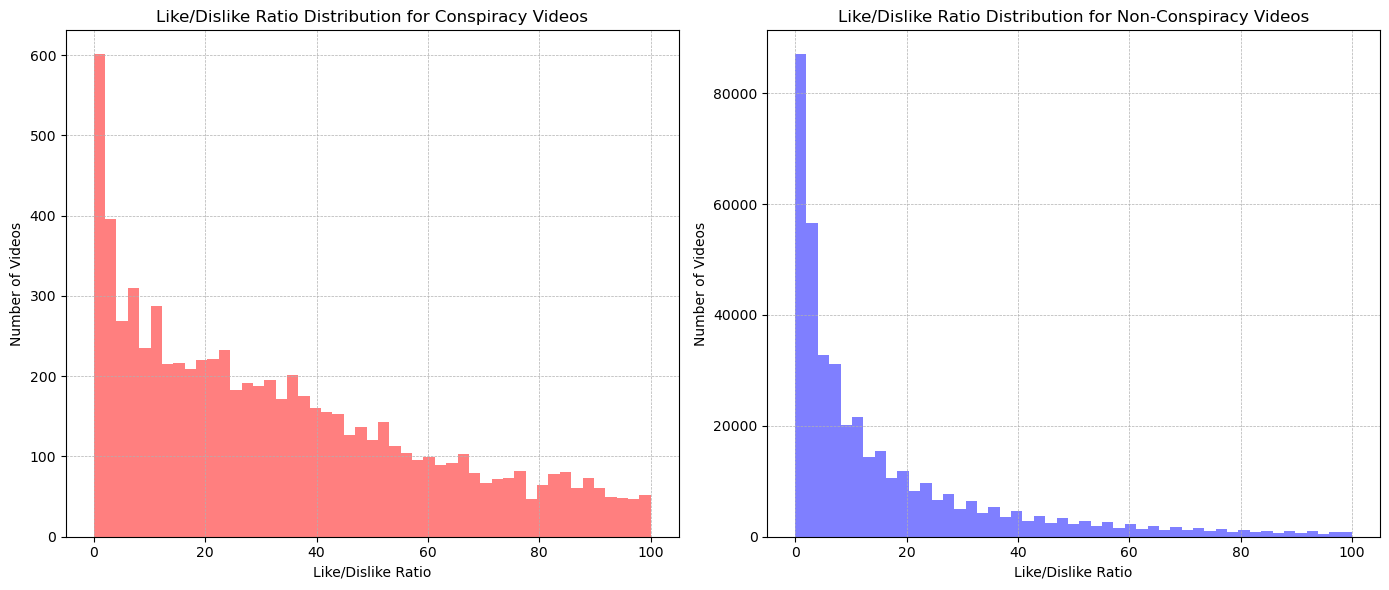

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Filter conspiracy and non-conspiracy DataFrames
conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]
non_conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 0]

# Plot 1: View Count Distribution (Log Scale)
plt.figure(figsize=(14, 6))

# Conspiracy
plt.subplot(1, 2, 1)
view_counts_conspiracy = conspiracy_df['view_count']
view_counts_conspiracy = view_counts_conspiracy[view_counts_conspiracy > 0]
plt.hist(view_counts_conspiracy, bins=np.logspace(np.log10(view_counts_conspiracy.min()), np.log10(view_counts_conspiracy.max()), 50), alpha=0.5, color='r')
plt.xscale('log')
plt.xlabel('View Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('View Count Distribution for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
view_counts_non_conspiracy = non_conspiracy_df['view_count']
view_counts_non_conspiracy = view_counts_non_conspiracy[view_counts_non_conspiracy > 0]
plt.hist(view_counts_non_conspiracy, bins=np.logspace(np.log10(view_counts_non_conspiracy.min()), np.log10(view_counts_non_conspiracy.max()), 50), alpha=0.5, color='b')
plt.xscale('log')
plt.xlabel('View Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('View Count Distribution for Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Plot 2: Like vs Dislike Scatter Plot (Log Scale)
plt.figure(figsize=(14, 12))
# Plotting Histograms
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation
# Like Counts for Conspiracy Videos
like_counts_conspiracy = conspiracy_df['like_count']
like_counts_conspiracy = like_counts_conspiracy[like_counts_conspiracy > 0]

# Dislike Counts for Conspiracy Videos
dislike_counts_conspiracy = conspiracy_df['dislike_count']
dislike_counts_conspiracy = dislike_counts_conspiracy[dislike_counts_conspiracy > 0]

# Like Counts for Non-Conspiracy Videos
like_counts_non_conspiracy = non_conspiracy_df['like_count']
like_counts_non_conspiracy = like_counts_non_conspiracy[like_counts_non_conspiracy > 0]

# Dislike Counts for Non-Conspiracy Videos
dislike_counts_non_conspiracy = non_conspiracy_df['dislike_count']
dislike_counts_non_conspiracy = dislike_counts_non_conspiracy[dislike_counts_non_conspiracy > 0]

# Adjust the figure size to accommodate four plots in one row
plt.figure(figsize=(28, 6))

# Subplot 1: Like Counts for Conspiracy Videos
plt.subplot(1, 4, 1)
plt.hist(
    like_counts_conspiracy,
    bins=np.logspace(
        np.log10(like_counts_conspiracy.min()),
        np.log10(like_counts_conspiracy.max()),
        50
    ),
    alpha=0.7,
    color='red'
)
plt.xscale('log')
plt.xlabel('like Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('like Count Distribution\nfor Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Subplot 2: Dislike Counts for Conspiracy Videos
plt.subplot(1, 4, 2)
plt.hist(
    dislike_counts_conspiracy,
    bins=np.logspace(
        np.log10(dislike_counts_conspiracy.min()),
        np.log10(dislike_counts_conspiracy.max()),
        50
    ),
    alpha=0.7,
    color='red'
)
plt.xscale('log')
plt.xlabel('Dislike Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Dislike Count Distribution\nfor Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Subplot 3: Like Counts for Non-Conspiracy Videos
plt.subplot(1, 4, 3)
plt.hist(
    like_counts_non_conspiracy,
    bins=np.logspace(
        np.log10(like_counts_non_conspiracy.min()),
        np.log10(like_counts_non_conspiracy.max()),
        50
    ),
    alpha=0.7,
    color='blue'
)
plt.xscale('log')
plt.xlabel('Like Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Like Count Distribution\nfor Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Subplot 4: Dislike Counts for Non-Conspiracy Videos
plt.subplot(1, 4, 4)
plt.hist(
    dislike_counts_non_conspiracy,
    bins=np.logspace(
        np.log10(dislike_counts_non_conspiracy.min()),
        np.log10(dislike_counts_non_conspiracy.max()),
        50
    ),
    alpha=0.7,
    color='blue'
)
plt.xscale('log')
plt.xlabel('Dislike Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Dislike Count Distribution\nfor Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Plot 3: Like/Dislike Ratio Distribution (Log Scale)
plt.figure(figsize=(14, 6))


# Conspiracy
plt.subplot(1, 2, 1)
like_count_conspiracy = conspiracy_df['like_count'].replace(0,0.25)
dislike_count_conspiracy = conspiracy_df['dislike_count'].replace(0, 0.25)
conspiracy_df['like_dislike_ratio'] = like_count_conspiracy / dislike_count_conspiracy
# conspiracy_df.loc[conspiracy_df['like_dislike_ratio'] < 1, 'like_dislike_ratio'] = (dislike_count_conspiracy / like_count_conspiracy) - 1
ratio_data_conspiracy = conspiracy_df['like_dislike_ratio'].dropna()
plt.hist(ratio_data_conspiracy, bins=np.linspace(0, 100, 50), alpha=0.5, color='r')
plt.xlabel('Like/Dislike Ratio')
plt.ylabel('Number of Videos')
plt.title('Like/Dislike Ratio Distribution for Conspiracy Videos')
plt.grid(True, linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
like_count_non_conspiracy = non_conspiracy_df['like_count'].replace(0,0.25)
dislike_count_non_conspiracy = non_conspiracy_df['dislike_count'].replace(0, 0.25)
non_conspiracy_df['like_dislike_ratio'] = like_count_non_conspiracy / dislike_count_non_conspiracy
# non_conspiracy_df.loc[non_conspiracy_df['like_dislike_ratio'] < 1, 'like_dislike_ratio'] = (dislike_count_non_conspiracy / like_count_non_conspiracy) - 1
ratio_data_non_conspiracy = non_conspiracy_df['like_dislike_ratio'].dropna()
plt.hist(ratio_data_non_conspiracy, bins=np.linspace(0, 100, 50), alpha=0.5, color='b')
plt.xlabel('Like/Dislike Ratio')
plt.ylabel('Number of Videos')
plt.title('Like/Dislike Ratio Distribution for Non-Conspiracy Videos')
plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


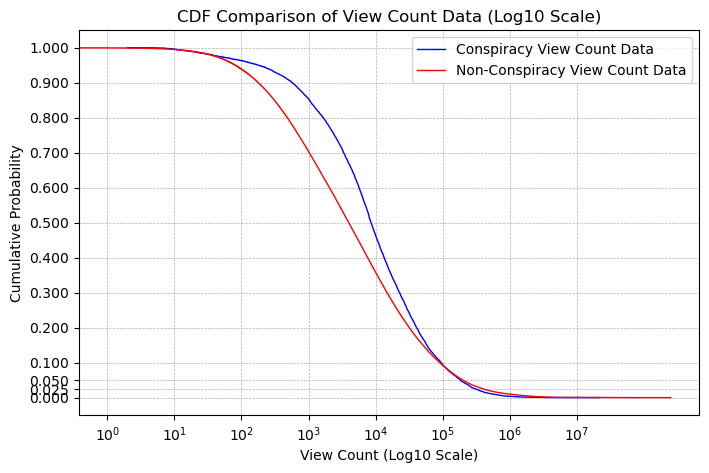

In [ ]:
view_data1 = np.sort(conspiracy_df['view_count'].dropna())
view_cdf1 = 1 - np.arange(1, len(view_data1) + 1) / len(view_data1)

view_data2 = np.sort(non_conspiracy_df['view_count'].dropna())
view_cdf2 = 1 - np.arange(1, len(view_data2) + 1) / len(view_data2)
# conspiracy_data = [{"x": float(x), "y": float(y)} for x, y in zip(view_data1, view_cdf1)]
# non_conspiracy_data = [{"x": float(x), "y": float(y)} for x, y in zip(view_data2, view_cdf2)]

plt.figure(figsize=(8, 5))
plt.plot(view_data1, view_cdf1, label='Conspiracy View Count Data', linewidth=1, color='blue')
plt.plot(view_data2, view_cdf2, label='Non-Conspiracy View Count Data', linewidth=1, color='red')
plt.xscale('log')
plt.title('CDF Comparison of View Count Data (Log10 Scale)')
plt.xlabel('View Count (Log10 Scale)')
xticks = [10**i for i in range(0, 8)]  # 10^0 to 10^7
plt.xticks(xticks, labels=[f"$10^{i}$" for i in range(0, 8)])
plt.ylabel('Cumulative Probability')
plt.yticks([0.0, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

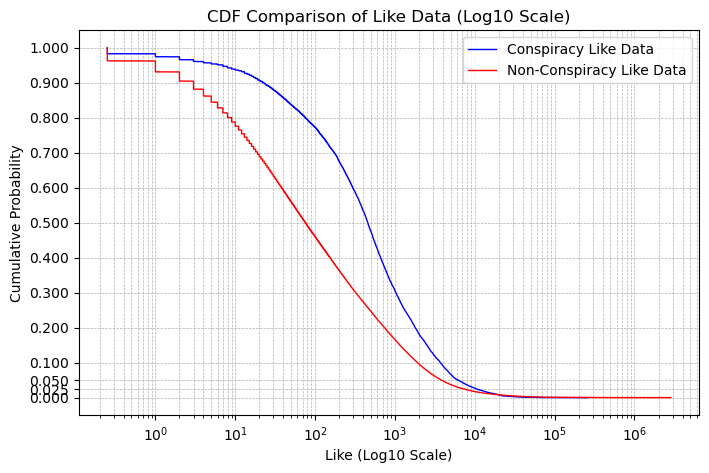

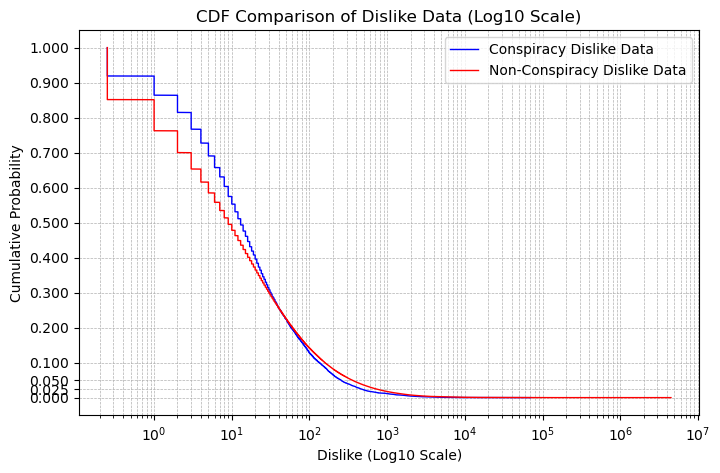

In [ ]:
# like CCDF
like_data1 = np.sort(conspiracy_df['like_count'].dropna().replace(0, 0.25))
like_cdf1 = 1 - np.arange(1, len(like_data1) + 1) / len(like_data1)

like_data2 = np.sort(non_conspiracy_df['like_count'].dropna().replace(0, 0.25))
like_cdf2 = 1 - np.arange(1, len(like_data2) + 1) / len(like_data2)

# dislike CCDF
dislike_data1 = np.sort(conspiracy_df['dislike_count'].dropna().replace(0, 0.25))
dislike_cdf1 = 1 - np.arange(1, len(dislike_data1) + 1) / len(dislike_data1)

dislike_data2 = np.sort(non_conspiracy_df['dislike_count'].dropna().replace(0, 0.25))
dislike_cdf2 = 1 - np.arange(1, len(dislike_data2) + 1) / len(dislike_data2)

plt.figure(figsize=(8, 5))
plt.plot(like_data1, like_cdf1, label='Conspiracy Like Data', linewidth=1, color='blue')
plt.plot(like_data2, like_cdf2, label='Non-Conspiracy Like Data', linewidth=1, color='red')
plt.xscale('log')
plt.title('CDF Comparison of Like Data (Log10 Scale)')
plt.xlabel('Like (Log10 Scale)')
plt.ylabel('Cumulative Probability')
plt.yticks([0.0, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(dislike_data1, dislike_cdf1, label='Conspiracy Dislike Data', linewidth=1, color='blue')
plt.plot(dislike_data2, dislike_cdf2, label='Non-Conspiracy Dislike Data', linewidth=1, color='red')
plt.xscale('log')
plt.title('CDF Comparison of Dislike Data (Log10 Scale)')
plt.xlabel('Dislike (Log10 Scale)')
plt.ylabel('Cumulative Probability')
plt.yticks([0.0, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

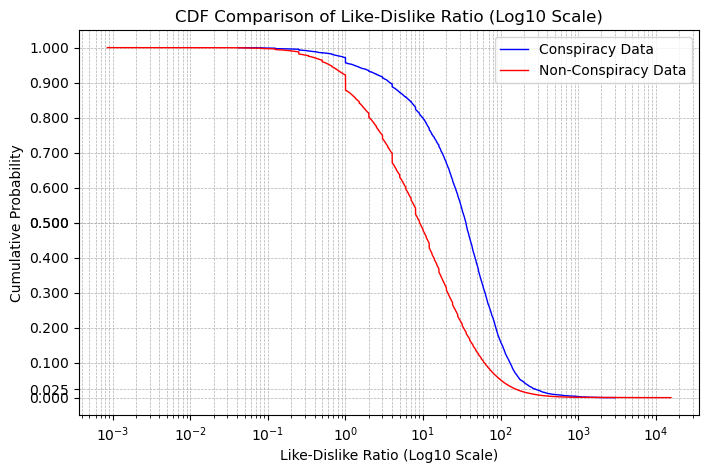

In [ ]:
data1 = np.sort(conspiracy_df['like_dislike_ratio'].dropna())
cdf1 = 1- np.arange(1, len(data1) + 1) / len(data1)

data2 = np.sort(non_conspiracy_df['like_dislike_ratio'].dropna())
cdf2 = 1- np.arange(1, len(data2) + 1) / len(data2)

# plot CCDF of like-dislike ratio
plt.figure(figsize=(8, 5))

plt.plot(data1, cdf1, label='Conspiracy Data', linewidth=1, color='blue')

plt.plot(data2, cdf2, label='Non-Conspiracy Data', linewidth=1, color='red')

plt.xscale('log') 
plt.title('CDF Comparison of Like-Dislike Ratio (Log10 Scale)')
plt.xlabel('Like-Dislike Ratio (Log10 Scale)')
plt.ylabel('Cumulative Probability')
# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 1.0])
plt.yticks([0.0, 0.025, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

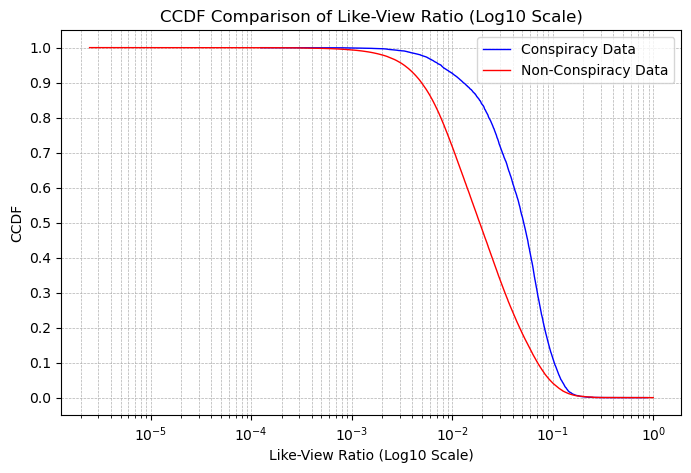

In [ ]:
like_view_ratio1 = conspiracy_df['like_count'].dropna().replace(0, 0.25) / conspiracy_df['view_count'].dropna().replace(0, 1)
like_view_ratio2 = non_conspiracy_df['like_count'].dropna().replace(0, 0.25) / non_conspiracy_df['view_count'].dropna().replace(0, 1)
like_view_ratio1 = np.clip(like_view_ratio1, 1e-6, 1).dropna()
like_view_ratio2 = np.clip(like_view_ratio2, 1e-6, 1).dropna()

like_view_ratio1 = np.sort(like_view_ratio1)
like_view_ratio2 = np.sort(like_view_ratio2)

like_view_ratio_cdf1 = 1 - np.arange(1, len(like_view_ratio1) + 1) / len(like_view_ratio1)
like_view_ratio_cdf2 = 1 - np.arange(1, len(like_view_ratio2) + 1) / len(like_view_ratio2)

# plot CCDF of like-view ratio
plt.figure(figsize=(8, 5))

plt.plot(like_view_ratio1, like_view_ratio_cdf1, label='Conspiracy Data', linewidth=1, color='blue')
plt.plot(like_view_ratio2, like_view_ratio_cdf2, label='Non-Conspiracy Data', linewidth=1, color='red')

plt.xscale('log')
plt.title('CCDF Comparison of Like-View Ratio (Log10 Scale)')
plt.xlabel('Like-View Ratio (Log10 Scale)')
plt.ylabel('CCDF')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()

plt.savefig('like_view_ratio_comparison.png', dpi=300)
plt.show()

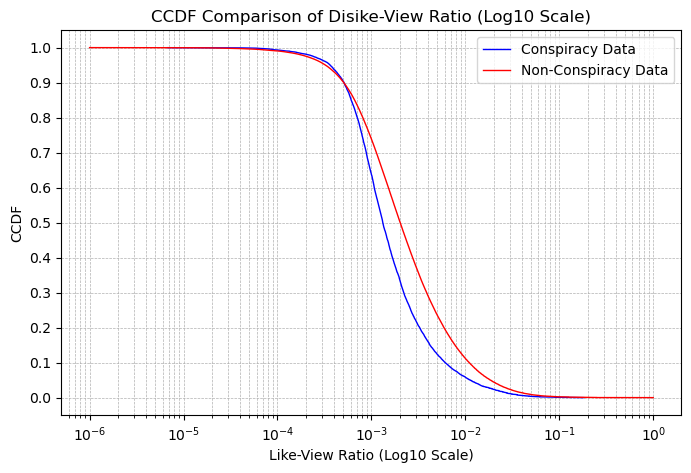

In [ ]:

dislike_view_ratio1 = conspiracy_df['dislike_count'].dropna().replace(0, 0.25) / conspiracy_df['view_count'].dropna().replace(0, 1)
dislike_view_ratio2 = non_conspiracy_df['dislike_count'].dropna().replace(0, 0.25) / non_conspiracy_df['view_count'].dropna().replace(0, 1)
dislike_view_ratio1 = np.clip(dislike_view_ratio1, 1e-6, 1).dropna()
dislike_view_ratio2 = np.clip(dislike_view_ratio2, 1e-6, 1).dropna()

dislike_view_ratio1 = np.sort(dislike_view_ratio1)
dislike_view_ratio2 = np.sort(dislike_view_ratio2)

dislike_view_ratio_cdf1 = 1 - np.arange(1, len(dislike_view_ratio1) + 1) / len(dislike_view_ratio1)
dislike_view_ratio_cdf2 = 1 - np.arange(1, len(dislike_view_ratio2) + 1) / len(dislike_view_ratio2)


# plot CCDF of like-view ratio
plt.figure(figsize=(8, 5))

plt.plot(dislike_view_ratio1, dislike_view_ratio_cdf1, label='Conspiracy Data', linewidth=1, color='blue')
plt.plot(dislike_view_ratio2, dislike_view_ratio_cdf2, label='Non-Conspiracy Data', linewidth=1, color='red')

plt.xscale('log')
plt.title('CCDF Comparison of Disike-View Ratio (Log10 Scale)')
plt.xlabel('Like-View Ratio (Log10 Scale)')
plt.ylabel('CCDF')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()

plt.savefig('dislike_view_ratio_comparison.png', dpi=300)
plt.show()


In [ ]:
from scipy import stats
import numpy as np
# Make sure view_count is not NaN
conspiracy_df['view_count'] = conspiracy_df['view_count'].replace(0, 1)
non_conspiracy_df['view_count'] = non_conspiracy_df['view_count'].replace(0, 1)

conspiracy_view_counts = conspiracy_df['view_count'].dropna()
non_conspiracy_view_counts = non_conspiracy_df['view_count'].dropna()
# Perform Mann-Whitney U test
from scipy.stats import mannwhitneyu

t_stat, p_value_two_sided = mannwhitneyu(conspiracy_view_counts, non_conspiracy_view_counts)

# Convert to one-sided p-value
# We're interested in whether conspiracy videos have *more* views, so we halve the two-sided p-value if t-statistic is positive
if t_stat > 0:
    p_value_one_sided = p_value_two_sided / 2
else:
    p_value_one_sided = 1 - (p_value_two_sided / 2)

print(f"T-statistic: {t_stat}, one-sided p-value: {p_value_one_sided}")

# Interpret the results for one-sided test
if p_value_one_sided < 0.05:
    print("Results are significant: Conspiracy videos have significantly more view counts than non-conspiracy videos.")
elif 1 - p_value_one_sided < 0.05:
    print("Results are significant: Conspiracy videos have significantly less view counts than non-conspiracy videos.")
else:
    print("Results are not significant: No significant evidence that conspiracy videos have more view counts than non-conspiracy videos.")


T-statistic: 2351163165.5, one-sided p-value: 5.6346069368654465e-192
Results are significant: Conspiracy videos have significantly more view counts than non-conspiracy videos.


/tmp/ipykernel_4101123/2184208441.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4101123/2184208441.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
from scipy import stats
import numpy as np

# Make copies to avoid SettingWithCopyWarning
conspiracy_df = conspiracy_df.copy()
non_conspiracy_df = non_conspiracy_df.copy()


conspiracy_like_count = np.log(conspiracy_df['like_count'].replace(0, 0.1).dropna())
non_conspiracy_like_count = np.log(non_conspiracy_df['like_count'].replace(0, 0.1).dropna())

conspiracy_dislike_count = np.log(conspiracy_df['dislike_count'].replace(0, 0.1).dropna())
non_conspiracy_dislike_count = np.log(non_conspiracy_df['dislike_count'].replace(0, 0.1).dropna())

# perform mannwhitneyu test
if len(conspiracy_like_count.unique()) > 1 and len(non_conspiracy_like_count.unique()) > 1:
    # T-test - Like Count
    t_stat_like, p_value_like = mannwhitneyu(conspiracy_like_count, non_conspiracy_like_count)
    print(f"Like Count - T-statistic: {t_stat_like}, p-value: {p_value_like}")

    if p_value_like < 0.05:
        if t_stat_like > 0:
            print("Conspiracy videos have significantly more likes than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have significantly more likes than conspiracy videos.")
    else:
        print("No significant difference in like count between conspiracy and non-conspiracy videos.")
else:
    print("Like Count: One or both groups have zero variance, cannot perform t-test.")

if len(conspiracy_dislike_count.unique()) > 1 and len(non_conspiracy_dislike_count.unique()) > 1:
    t_stat_dislike, p_value_dislike = mannwhitneyu(conspiracy_dislike_count, non_conspiracy_dislike_count)
    print(f"\nDislike Count - T-statistic: {t_stat_dislike}, p-value: {p_value_dislike}")

    if p_value_dislike < 0.05:
        if t_stat_dislike > 0:
            print("Conspiracy videos have significantly more dislikes than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have significantly more dislikes than conspiracy videos.")
    else:
        print("No significant difference in dislike count between conspiracy and non-conspiracy videos.")
else:
    print("Dislike Count: One or both groups have zero variance, cannot perform t-test.")

# Drop missing values (NaN) in like_dislike_rate
conspiracy_like_dislike_rate = conspiracy_df['like_dislike_ratio'].dropna()
non_conspiracy_like_dislike_rate = non_conspiracy_df['like_dislike_ratio'].dropna()
from scipy.stats import mannwhitneyu

t_stat_rate, p_value_rate = mannwhitneyu(conspiracy_view_counts, non_conspiracy_view_counts)
if len(conspiracy_like_dislike_rate.unique()) > 1 and len(non_conspiracy_like_dislike_rate.unique()) > 1:
    print(f"\nLike-Dislike Rate - T-statistic: {t_stat_rate}, p-value: {p_value_rate}")

    if p_value_rate < 0.05:
        if t_stat_rate > 0:
            print("Conspiracy videos have a significantly higher like-dislike ratio than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have a significantly higher like-dislike ratio than conspiracy videos.")
    else:
        print("No significant difference in the like-dislike ratio between conspiracy and non-conspiracy videos.")
else:
    print("Like-Dislike Rate: One or both groups have zero variance, cannot perform t-test.")


Like Count - T-statistic: 2626975335.0, p-value: 0.0
Conspiracy videos have significantly more likes than non-conspiracy videos.

Dislike Count - T-statistic: 2097074046.0, p-value: 3.151107229671464e-52
Conspiracy videos have significantly more dislikes than non-conspiracy videos.

Like-Dislike Rate - T-statistic: 2351163165.5, p-value: 1.1269213873730893e-191
Conspiracy videos have a significantly higher like-dislike ratio than non-conspiracy videos.


In [ ]:
from scipy.stats import ranksums
# perform wilcoxon rank-sum test
stat, p_value = ranksums(like_view_ratio1, like_view_ratio2)
print(f"Wilcoxon Rank-Sum Test - Like-View Ratio: Statistic = {stat}, p-value = {p_value}")
if p_value < 0.01:
    if stat > 0:
        print("Conspiracy videos have a significantly higher Like-View Ratio.")
    else:
        print("Non-Conspiracy videos have a significantly higher Like-View Ratio.")
else:
    print("No significant difference in Like-View Ratio.")

stat2, p_value2 = ranksums(dislike_view_ratio1, dislike_view_ratio2)
print(f"Wilcoxon Rank-Sum Test - Dislike-View Ratio: Statistic = {stat2}, p-value = {p_value2}")
if p_value2 < 0.01:
    if stat2 > 0:
        print("Conspiracy videos have a significantly higher Dislike-View Ratio.")
    else:
        print("Non-Conspiracy videos have a significantly higher Dislike-View Ratio.")
else:
    print("No significant difference in Dislike-View Ratio.")


Wilcoxon Rank-Sum Test - Like-View Ratio: Statistic = 77.81492742957741, p-value = 0.0
Conspiracy videos have a significantly higher Like-View Ratio.
Wilcoxon Rank-Sum Test - Dislike-View Ratio: Statistic = -30.733028694254127, p-value = 2.0614356439212524e-207
Non-Conspiracy videos have a significantly higher Dislike-View Ratio.


In [ ]:
conspiracy_df['new_metric'] = (conspiracy_df['like_count'] - 0.5 * conspiracy_df['dislike_count']) / conspiracy_df['view_count']
non_conspiracy_df['new_metric'] = (non_conspiracy_df['like_count'] - 0.5 * non_conspiracy_df['dislike_count']) / non_conspiracy_df['view_count']
print(conspiracy_df['new_metric'].describe())
print(non_conspiracy_df['new_metric'].describe())

# Perform t-test to compare the new_metric between conspiracy and non-conspiracy videos
t_stat, p_value = stats.mannwhitneyu(conspiracy_df['new_metric'].dropna(), non_conspiracy_df['new_metric'].dropna())
print(f"T-statistic: {t_stat}, p-value: {p_value}")
# Interpret the results
if p_value < 0.05:
    if t_stat > 0:
        print("Conspiracy videos have a significantly larger new_metric than non-conspiracy videos.")
    else:
        print("Non-conspiracy videos have a significantly larger new_metric than conspiracy videos.")
else:
    print("No significant difference in new_metric between conspiracy and non-conspiracy videos.")

count   8,854.00
mean        0.05
std         0.04
min        -0.09
25%         0.03
50%         0.05
75%         0.07
max         0.87
Name: new_metric, dtype: float64
count   432,978.00
mean          0.03
std           0.05
min          -6.22
25%           0.01
50%           0.02
75%           0.04
max          21.75
Name: new_metric, dtype: float64
T-statistic: 2842165192.5, p-value: 0.0
Conspiracy videos have a significantly larger new_metric than non-conspiracy videos.


# TASK3

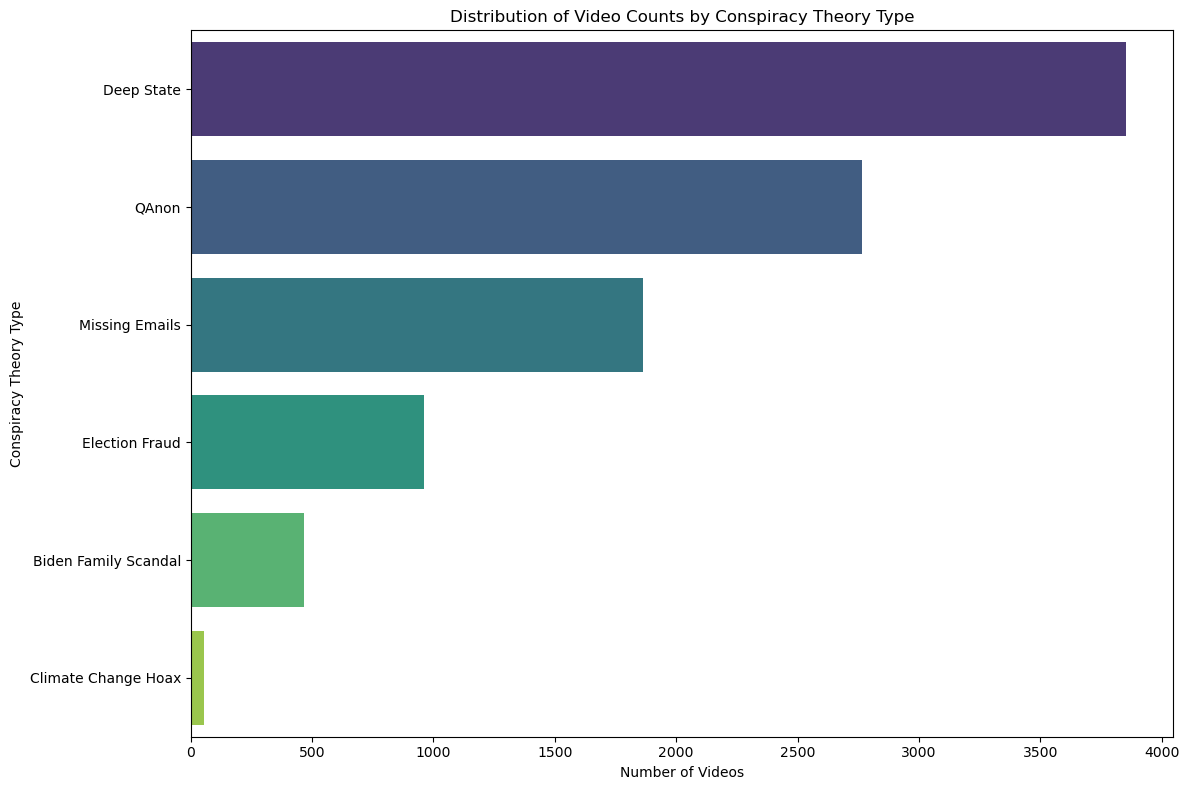

In [ ]:
# Calculate the number of videos for each type of conspiracy theory
type_counts = df_combined_with_conspiracy[list(conspiracy_keywords.keys())].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=type_counts.values, y=type_counts.index, palette='viridis')
plt.title('Distribution of Video Counts by Conspiracy Theory Type')
plt.xlabel('Number of Videos')
plt.ylabel('Conspiracy Theory Type')
plt.tight_layout()
plt.show()


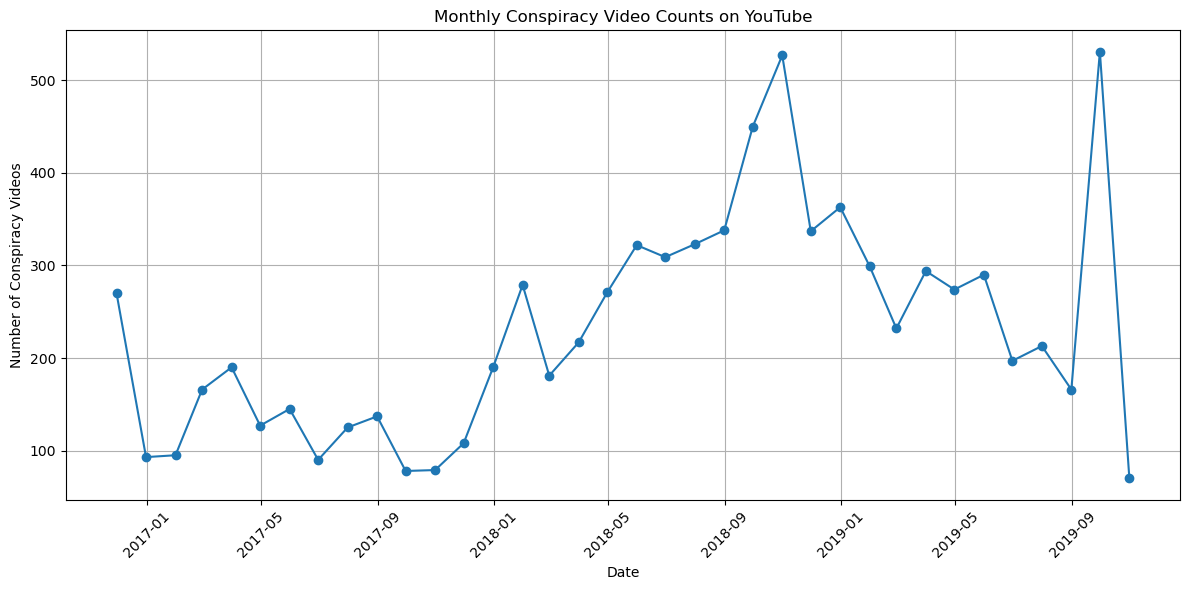

In [ ]:
data = pd.read_csv('conspiracy_videos.csv')

data['upload_date'] = pd.to_datetime(data['upload_date'])
conspiracy_data = data[(data['is_conspiracy'] == 1) & (data['upload_date'] >= '2016-11-01')]

monthly_counts = conspiracy_data.resample('M', on='upload_date').size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title('Monthly Conspiracy Video Counts on YouTube')
plt.xlabel('Date')
plt.ylabel('Number of Conspiracy Videos')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### A time-series analysis of these videos revealed two primary peaks in content volume: October 2018, coinciding with the U.S. midterm elections, and November 2019, aligning with the start of impeachment discussions. Given the significance of these periods, we focused our analysis on them.

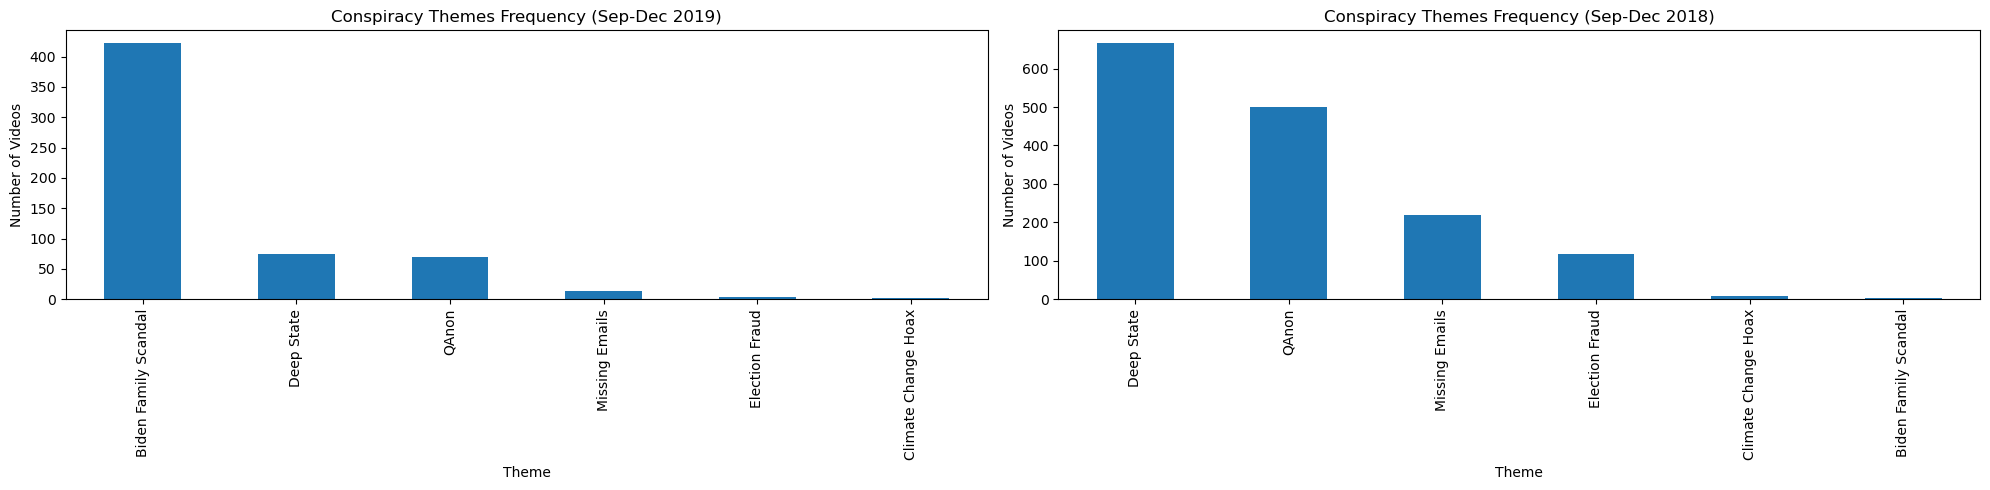

In [36]:
data = pd.read_csv('conspiracy_videos.csv')
data['upload_date'] = pd.to_datetime(data['upload_date'])

# Define the study periods
study_periods = {
    'Sep-Dec 2019': ('2019-09-10', '2019-12-10'),
    'Sep-Dec 2018': ('2018-09-10', '2018-12-10')
}

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Define themes
themes = ['Deep State', 'Election Fraud', 'QAnon', 'Missing Emails', 'Biden Family Scandal', 'Climate Change Hoax']

# Plot for each period
for ax, (period, (start_date, end_date)) in zip(axes, study_periods.items()):
    study_period_data = data[(data['is_conspiracy'] == 1) &
                             (data['upload_date'] >= start_date) &
                             (data['upload_date'] <= end_date)]
    
    theme_counts = study_period_data[themes].sum().sort_values(ascending=False)
    theme_counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Conspiracy Themes Frequency ({period})')
    ax.set_xlabel('Theme')
    ax.set_ylabel('Number of Videos')

plt.tight_layout()
plt.show()


#### From September to December 2019, mentions of the *Biden Family Scandal* surged in conspiracy content, driven by Trump’s focus on alleged Biden corruption amid the impeachment inquiry. Trump emphasized Hunter Biden’s Ukraine dealings to cast doubt on his political opponent and counter the impeachment narrative, fueling widespread conspiracy theories across media platforms.

#### From September to December 2018, "Deep State" and "QAnon" mentions spiked as Trump frequently referenced these conspiracies during the midterm election campaign. By highlighting the "Deep State," he sought to energize his base and frame opposition as part of a hidden government conspiracy, driving public interest and a surge of related content online.

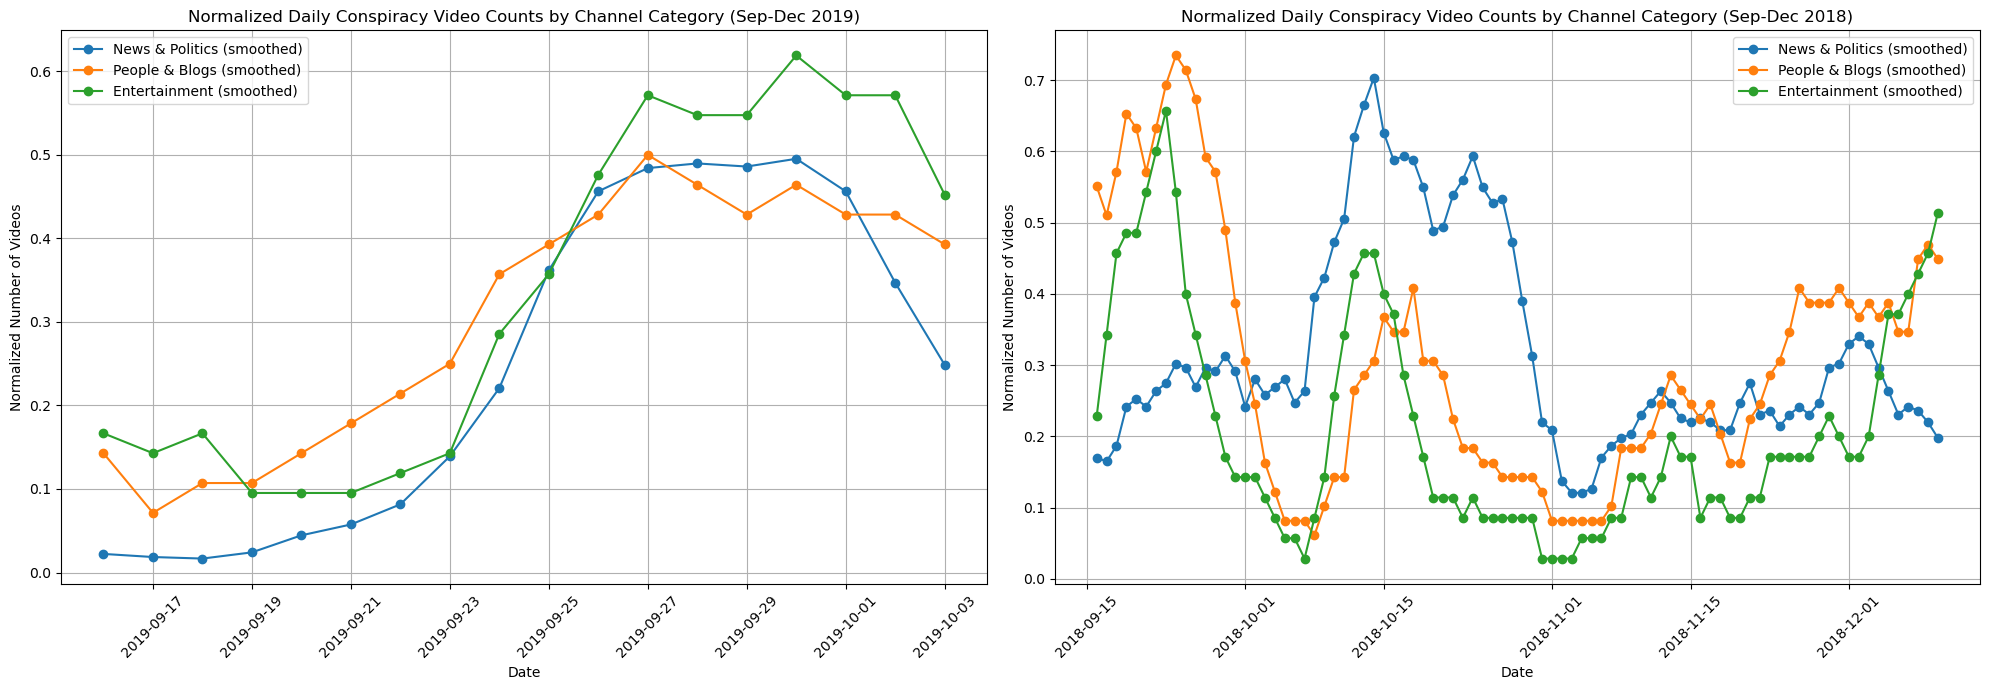

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load data and convert the date column to datetime format
data = pd.read_csv('conspiracy_videos.csv')
data['upload_date'] = pd.to_datetime(data['upload_date'])

# Define study periods
study_periods = {
    'Sep-Dec 2019': ('2019-09-10', '2019-12-10'),
    'Sep-Dec 2018': ('2018-09-10', '2018-12-10')
}

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Channel categories
categories = ['News & Politics', 'People & Blogs', 'Entertainment']

# Iterate over each study period
for ax, (period, (start_date, end_date)) in zip(axes, study_periods.items()):
    # Filter data
    filtered_data = data[(data['is_conspiracy'] == 1) &
                         (data['upload_date'] >= start_date) &
                         (data['upload_date'] <= end_date) &
                         (data['category_cc'].isin(categories))]

    # Count data by date and category
    daily_counts = filtered_data.groupby(['upload_date', 'category_cc']).size().unstack(fill_value=0)
    
    # Normalize data
    scaler = MinMaxScaler()
    normalized_counts = pd.DataFrame(scaler.fit_transform(daily_counts), 
                                     index=daily_counts.index, 
                                     columns=daily_counts.columns)
    
    # Smooth data
    window = 7
    smoothed_counts = normalized_counts.rolling(window=window).mean()

    # Plot each category's curve
    for category in categories:
        ax.plot(smoothed_counts.index, smoothed_counts[category], marker='o', label=f'{category} (smoothed)')
    
    # Set title and labels
    ax.set_title(f'Normalized Daily Conspiracy Video Counts by Channel Category ({period})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Normalized Number of Videos')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


#### To analyze the features we want from the rather messy time series plots, we need to further perform correlation calculations, which means using the principle of convolution to find the temporal order.




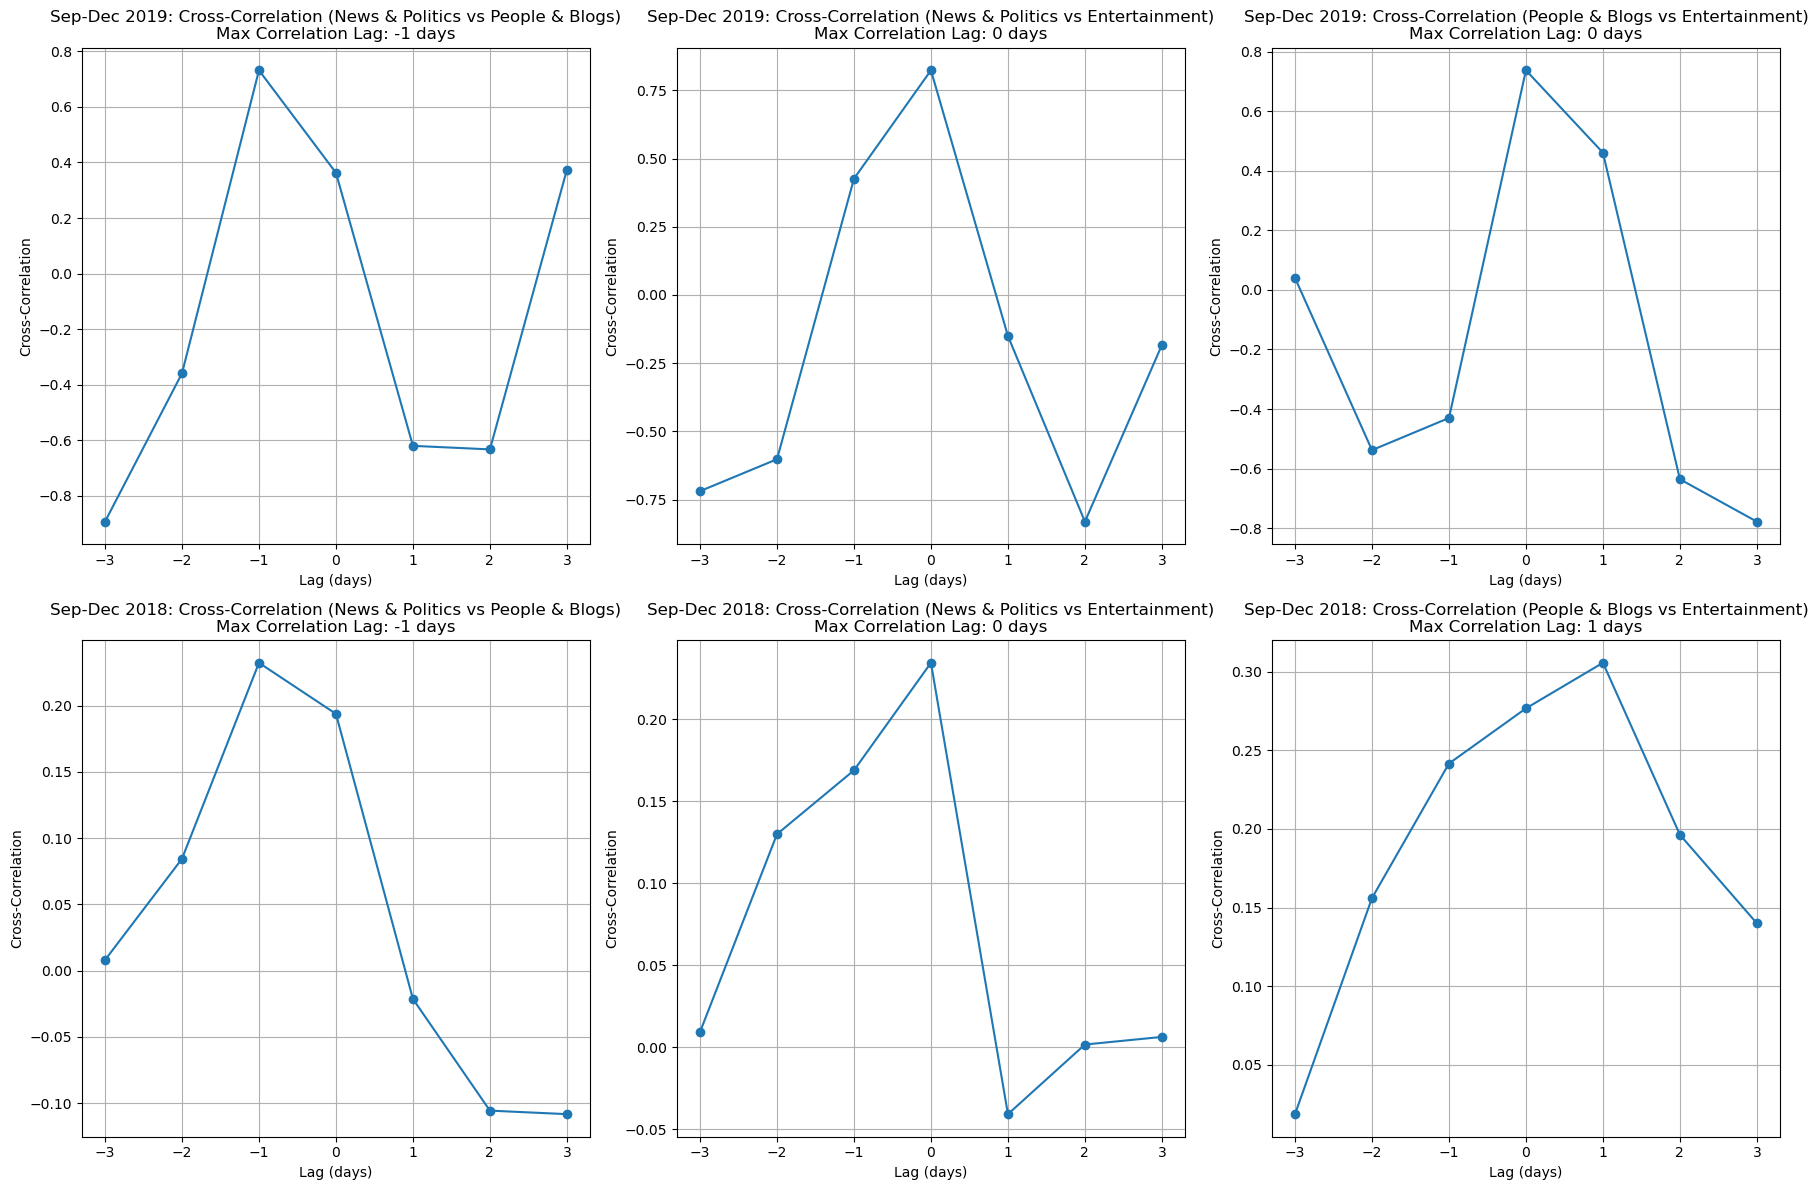

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and prepare data
data = pd.read_csv('conspiracy_videos.csv')
data['upload_date'] = pd.to_datetime(data['upload_date'])

# Define study periods
study_periods = {
    'Sep-Dec 2019': ('2019-09-26', '2019-12-25'),
    'Sep-Dec 2018': ('2018-09-26', '2018-12-25')
}

# Cross-correlation function
def cross_correlation(series1, series2, max_lag=3):
    # Create an array of lag values from -max_lag to max_lag
    lags = np.arange(-max_lag, max_lag + 1)
    
    # Calculate the correlation for each lag value
    correlations = [series1.corr(series2.shift(lag)) for lag in lags]
    
    # Return the lag values and their corresponding correlations
    return lags, correlations

# Plot setup
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (period, (start_date, end_date)) in enumerate(study_periods.items()):
    period_data = data[(data['is_conspiracy'] == 1) &
                       (data['upload_date'] >= start_date) &
                       (data['upload_date'] <= end_date) &
                       ((data['category_cc'] == 'News & Politics') |
                        (data['category_cc'] == 'People & Blogs') |
                        (data['category_cc'] == 'Entertainment'))]
    daily_counts = period_data.groupby(['upload_date', 'category_cc']).size().unstack(fill_value=0)
    scaler = MinMaxScaler()
    normalized_counts = pd.DataFrame(scaler.fit_transform(daily_counts),
                                     index=daily_counts.index,
                                     columns=daily_counts.columns)

    # Calculate cross-correlations and find max lags
    lags, correlations_np_pb = cross_correlation(normalized_counts['News & Politics'], normalized_counts['People & Blogs'])
    max_lag_np_pb = lags[np.argmax(correlations_np_pb)]

    lags, correlations_np_ent = cross_correlation(normalized_counts['News & Politics'], normalized_counts['Entertainment'])
    max_lag_np_ent = lags[np.argmax(correlations_np_ent)]

    lags, correlations_pb_ent = cross_correlation(normalized_counts['People & Blogs'], normalized_counts['Entertainment'])
    max_lag_pb_ent = lags[np.argmax(correlations_pb_ent)]

    # Plot cross-correlations for each category pair with max lag displayed
    axes[idx, 0].plot(lags, correlations_np_pb, marker='o')
    axes[idx, 0].set_title(f'{period}: Cross-Correlation (News & Politics vs People & Blogs)\nMax Correlation Lag: {max_lag_np_pb} days')
    axes[idx, 0].set_xlabel('Lag (days)')
    axes[idx, 0].set_ylabel('Cross-Correlation')
    axes[idx, 0].grid(True)

    axes[idx, 1].plot(lags, correlations_np_ent, marker='o')
    axes[idx, 1].set_title(f'{period}: Cross-Correlation (News & Politics vs Entertainment)\nMax Correlation Lag: {max_lag_np_ent} days')
    axes[idx, 1].set_xlabel('Lag (days)')
    axes[idx, 1].set_ylabel('Cross-Correlation')
    axes[idx, 1].grid(True)

    axes[idx, 2].plot(lags, correlations_pb_ent, marker='o')
    axes[idx, 2].set_title(f'{period}: Cross-Correlation (People & Blogs vs Entertainment)\nMax Correlation Lag: {max_lag_pb_ent} days')
    axes[idx, 2].set_xlabel('Lag (days)')
    axes[idx, 2].set_ylabel('Cross-Correlation')
    axes[idx, 2].grid(True)

plt.tight_layout()
plt.show()


#### The images show cross-correlation of normalized video counts, where a negative lag at peak correlation indicates that the second channel type released content earlier. This highlights the sequential release pattern across channel categories.

#### The results indicate that Trump-related conspiracy content first appears in the People & Blogs category, followed by News & Politics and Entertainment. This sequence is understandable, as People & Blogs videos generally require minimal editing or production, reflecting the public's immediate response. For example, someone might record a segment of a Trump interview on their phone and post it online instantly. News & Politics content follows closely behind, as news segments typically involve more preparation and editing, leading to a slightly delayed release. Entertainment videos are posted later as entertainment creators tend to process information from blogs or news and take additional time to consider how best to adapt the content for maximum engagement, often through added commentary or creative reinterpretation.

# TASK4

### Transition: From Conspiracy Theories to Entertainment Channels

#### While conspiracy theories often dominate political discussions on YouTube, another critical facet of the platform lies in its entertainment content. Entertainment channels, with their vast reach and appeal, play a unique role in shaping audience engagement. Interestingly, these channels are not immune to the spread of conspiracy narratives, often packaging them in ways that maximize viewer interaction. By examining metrics like the **engagement_rate**, we can better understand the dynamics of audience response within this distinct category.

In [ ]:
df_timeseries = pd.read_csv('df_timeseries_en.tsv', sep='\t', parse_dates=['datetime'])
df_videos = pd.read_json('yt_metadata_filtered_"trump ".jsonl', lines=True)

df_trump_entertainment_videos = df_videos[df_videos['categories'] == 'Entertainment']
df_trump_non_entertainment_videos = df_videos[df_videos['categories'] != 'Entertainment']

print(f'the shape of entertainment videos are : {df_trump_entertainment_videos.shape}')
print(f'the shape of non-entertainment videos are : {df_trump_non_entertainment_videos.shape}')

the shape of entertainment videos are : (44392, 13)
the shape of non-entertainment videos are : (403224, 13)


### Exploring engagement_rate Differences Between Entertainment and Non-Entertainment Channels

#### To analyze audience engagement across different types of content, we calculated the **engagement_rate** using the formula:

#### $ \text{engagement\_rate} = \frac{\text{like} - (\text{dislike} \times 0.5)}{view\_count}$

#### This metric balances the positive feedback (likes) against negative feedback (dislikes), accounting for the fact that dislikes often carry less weight than likes in reflecting audience satisfaction. By scaling the result, the engagement_rate provides a normalized measure of engagement that allows meaningful comparisons across channels.

#### The chart below illustrates the distribution of like-ratio values for entertainment and non-entertainment channels. This visualization helps identify key differences in audience response, shedding light on how viewers perceive and interact with these two categories of content.We can find that for entertainment category videos, they have more tendency to have higher engagement_rate.

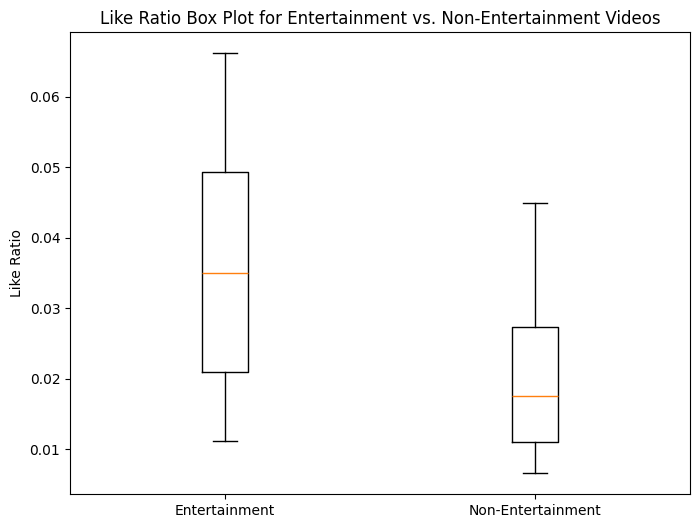

In [ ]:
# Compare the like ratios of entertainment and non-entertainment videos using the formula (like_count - 0.5*dislike_count)/view_count
# Filter out videos with view_count equal to 0
df_trump_entertainment_videos = df_trump_entertainment_videos[df_trump_entertainment_videos['view_count'] > 0]
df_trump_non_entertainment_videos = df_trump_non_entertainment_videos[df_trump_non_entertainment_videos['view_count'] > 0]

pd.options.mode.chained_assignment = None
df_trump_entertainment_videos['like_ratio'] = (df_trump_entertainment_videos['like_count'] - 0.5*df_trump_entertainment_videos['dislike_count']) / df_trump_entertainment_videos['view_count']
df_trump_non_entertainment_videos['like_ratio'] = (df_trump_non_entertainment_videos['like_count'] - 0.5*df_trump_non_entertainment_videos['dislike_count']) / df_trump_non_entertainment_videos['view_count']

# Sort
df_trump_entertainment_videos = df_trump_entertainment_videos.sort_values(by='like_ratio', ascending=False)
df_trump_non_entertainment_videos = df_trump_non_entertainment_videos.sort_values(by='like_ratio', ascending=False)

# Plot boxplot, to reduce error, only plot data between 25%-75%

df_trump_entertainment_videos_new = df_trump_entertainment_videos[df_trump_entertainment_videos['like_ratio'] > df_trump_entertainment_videos['like_ratio'].quantile(0.25)]
df_trump_entertainment_videos_new = df_trump_entertainment_videos_new[df_trump_entertainment_videos_new['like_ratio'] < df_trump_entertainment_videos_new['like_ratio'].quantile(0.75)]

df_trump_non_entertainment_videos_new = df_trump_non_entertainment_videos[df_trump_non_entertainment_videos['like_ratio'] > df_trump_non_entertainment_videos['like_ratio'].quantile(0.25)]
df_trump_non_entertainment_videos_new = df_trump_non_entertainment_videos_new[df_trump_non_entertainment_videos_new['like_ratio'] < df_trump_non_entertainment_videos_new['like_ratio'].quantile(0.75)]

plt.figure(figsize=(8, 6))
plt.boxplot([df_trump_entertainment_videos_new['like_ratio'], df_trump_non_entertainment_videos_new['like_ratio']], tick_labels=['Entertainment', 'Non-Entertainment'])
plt.title('Like Ratio Box Plot for Entertainment vs. Non-Entertainment Videos')
plt.ylabel('Like Ratio')
plt.show()

### Casual analysis for conspiracy words

#### analysize for the effect of like-ratio of videos after adding conspiracy words in the video title or descriptions

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Load the timeseries data and parse dates
df_timeseries = pd.read_csv('df_timeseries_en.tsv', sep='\t', parse_dates=['datetime'])
# Load the filtered YouTube metadata
df_videos = pd.read_json('yt_metadata_filtered_"trump ".jsonl', lines=True)

# Define conspiracy theory keywords and their related phrases
conspiracy_keywords = {
    "Deep State": ["deepstate", "deep state", "government faction", "shadow government", "hidden government"],
    "Election Fraud": ["election fraud", "vote fraud", "mail-in ballots", "voter suppression", "rigged election"],
    "QAnon": ["qanon", "cabal", "child trafficking", "satanic rituals", "deep-rooted cabal", "Q movement"],
    "Missing Emails": ["missing emails", "deleted emails", "clinton emails", "email scandal", "email leak"],
    "Biden Family Scandal": ["biden family scandal", "hunter biden", "biden corruption", "biden business dealings", "biden influence"],
    "Climate Change Hoax": ["climate change hoax", "global elites", "climate profit", "false climate", "climate deception"]
}

# Filter videos for the target channel
target_channel = 'UCLoNQH9RCndfUGOb2f7E1Ew'
df_videos_channel = df_videos[df_videos['channel_id'] == target_channel].copy()
df_timeseries_channel = df_timeseries[df_timeseries['channel'] == target_channel].copy()

print(df_videos_channel.shape)

# Detect conspiracy keywords in video metadata
# Initialize columns for each theory
detected_columns = {theory: [] for theory in conspiracy_keywords.keys()}

# Iterate through each video to check for conspiracy keywords in titles
for _, row in df_videos_channel.iterrows():
    text = str(row.get('title', '')).lower()  # Convert title to lowercase for case-insensitive matching
    
    for theory, keywords in conspiracy_keywords.items():
        # Create a regex pattern to match any of the defined keywords
        pattern = re.compile('|'.join([re.escape(word.lower()) for word in keywords]), re.IGNORECASE)
        # Append 1 if a keyword is found, otherwise append 0
        detected_columns[theory].append(1 if pattern.search(text) else 0)

# Add the detection results to the DataFrame
for theory, values in detected_columns.items():
    df_videos_channel.loc[:, theory] = values

# Add a column to indicate if a video contains any conspiracy-related keywords
df_videos_channel['is_conspiracy'] = df_videos_channel[
    list(conspiracy_keywords.keys())
].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# Basic statistics
total_videos = len(df_videos_channel)
conspiracy_videos = df_videos_channel[df_videos_channel['is_conspiracy'] == 1]
non_conspiracy_videos = df_videos_channel[df_videos_channel['is_conspiracy'] == 0]

# Print the statistics
print(f"Total videos: {total_videos}")
print(f"Conspiracy keyword videos: {len(conspiracy_videos)} ({len(conspiracy_videos)/total_videos*100:.2f}%)")


(15181, 13)
Total videos: 15181
Conspiracy keyword videos: 137 (0.90%)


In [15]:
import pandas as pd
from datetime import datetime
import numpy as np

def merge_channel_data(df_videos_channel, df_timeseries_channel):
    df_videos_channel['upload_date'] = pd.to_datetime(df_videos_channel['upload_date'])
    df_timeseries_channel['datetime'] = pd.to_datetime(df_timeseries_channel['datetime'])
    
    df_timeseries_channel = df_timeseries_channel.sort_values('datetime')
    df_result = df_videos_channel.copy()
    
    def binary_search_timeseries(upload_time):
        left, right = 0, len(df_timeseries_channel) - 1
        
        while left <= right:
            mid = (left + right) // 2
            current_datetime = df_timeseries_channel.iloc[mid]['datetime']
            
            if mid == len(df_timeseries_channel) - 1:
                return None
            
            next_datetime = df_timeseries_channel.iloc[mid + 1]['datetime']
            
            if current_datetime <= upload_time < next_datetime:
                return {
                    'subs': df_timeseries_channel.iloc[mid]['subs'],
                    'activity': df_timeseries_channel.iloc[mid]['activity'],
                    'delta_videos': df_timeseries_channel.iloc[mid]['delta_videos'],
                }
            
            if upload_time < current_datetime:
                right = mid - 1
            else:
                left = mid + 1
        
        return None
    
    for index, row in df_result.iterrows():
        result = binary_search_timeseries(row['upload_date'])
        
        if result is not None:
            df_result.at[index, 'subs'] = result['subs']
            df_result.at[index, 'activity'] = result['activity']
            df_result.at[index, 'delta_videos'] = result['delta_videos']
    
    
    return df_result

# Example usage
df_videos_channel = merge_channel_data(df_videos_channel, df_timeseries_channel)

# Remove rows where 'subs' is NaN
df_videos_channel = df_videos_channel.dropna(subset=['subs'])

# Calculate engagement rate
df_videos_channel['engagement_rate'] = (
    df_videos_channel['like_count'] - (df_videos_channel['dislike_count'] * 0.5)
) / df_videos_channel['view_count']

# Calculate propensity score
X = df_videos_channel[['duration','subs','activity','delta_videos']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ps_model = LogisticRegression()
ps_model.fit(X_scaled, df_videos_channel['is_conspiracy'])
df_videos_channel['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]


# Step 4: Nearest Neighbor Matching
from sklearn.neighbors import NearestNeighbors

# Separate conspiracy videos and non-conspiracy videos
treated = df_videos_channel[df_videos_channel['is_conspiracy'] == 1]
control = df_videos_channel[df_videos_channel['is_conspiracy'] == 0]

# Nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matching pairs
matched_control = control.iloc[indices.flatten()].copy()
matched_control['treated_index'] = treated.index

# Combine matched samples
matched = pd.concat([treated, matched_control], axis=0)

# Step 5: Analyze engagement rate differences
# Descriptive statistics
comparison = matched.groupby('is_conspiracy')['engagement_rate'].mean()
print("\nEngagement Rate Comparison:")
print(comparison)

from scipy.stats import shapiro, mannwhitneyu, ttest_ind

# Check normality
stat, p_value = shapiro(matched['view_count'])
print(f"Shapiro-Wilk Test: statistic={stat}, p-value={p_value}")

if p_value > 0.05:
    # Use T-Test
    t_stat, t_p = ttest_ind(
        matched[matched['is_conspiracy'] == 1]['engagement_rate'],
        matched[matched['is_conspiracy'] == 0]['engagement_rate']
    )
    print(f"\nT-Test: t-statistic={t_stat}, p-value={t_p}")
else:
    # Use Mann-Whitney U Test
    u_stat, u_p = mannwhitneyu(
        matched[matched['is_conspiracy'] == 1]['engagement_rate'],
        matched[matched['is_conspiracy'] == 0]['engagement_rate']
    )
    print(f"\nMann-Whitney U Test: statistic={u_stat}, p-value={u_p}")



Engagement Rate Comparison:
is_conspiracy
0    0.057420
1    0.063972
Name: engagement_rate, dtype: float64
Shapiro-Wilk Test: statistic=0.6091054958188235, p-value=2.2153800443910235e-23

Mann-Whitney U Test: statistic=9195.0, p-value=0.007651016017211883



#### To investigate the impact of conspiracy-related content on engagement rates within a single entertainment channel, I conducted a causal analysis. Focusing on videos from the same channel helps minimize audience-related confounding factors, ensuring a more controlled comparison. To further enhance the robustness of the results, I employed a matching method based on **propensity scores**, incorporating variables such as `video_count`, `subscription`, and `duration`—factors likely to influence engagement.

#### The results show a higher average engagement rate for videos containing conspiracy-related content (0.063972) compared to those without (0.057420). Statistical tests confirm these findings:

- **Shapiro-Wilk Test** indicates the data are not normally distributed (p-value < 0.001).
- **Mann-Whitney U Test** reveals a significant difference in engagement rates between the two groups (p-value = 0.0077).

#### The distribution of engagement rates for conspiracy and non-conspiracy videos is visualized in the chart below, highlighting the differences between the two categories.

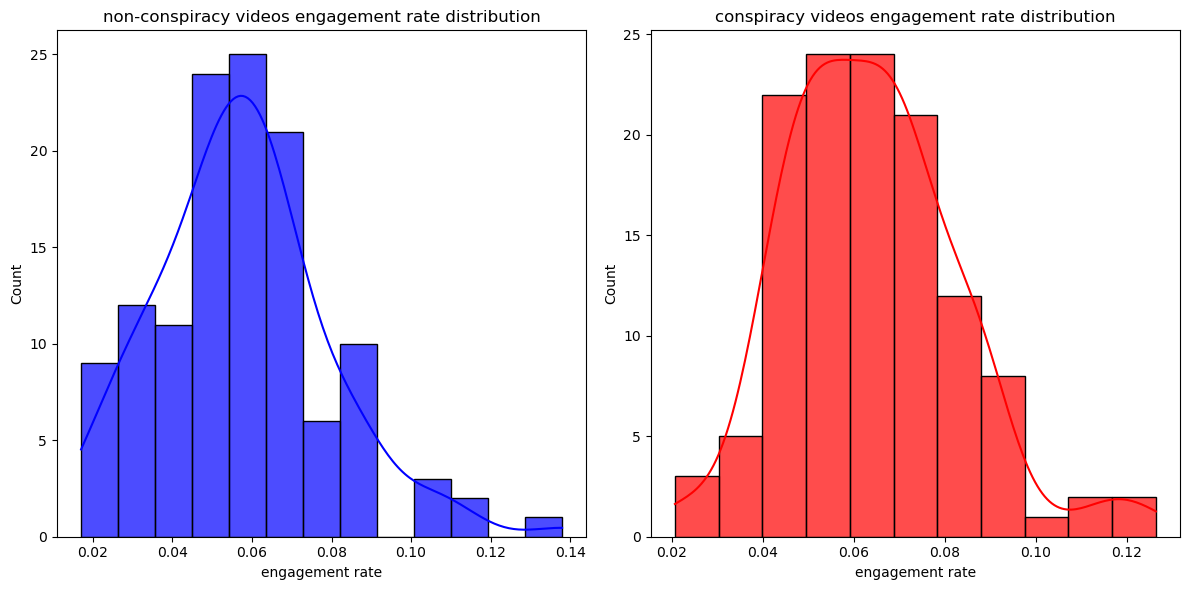

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=matched[matched['is_conspiracy'] == 0], 
             x='engagement_rate', kde=True, color='blue', alpha=0.7)
plt.title('non-conspiracy videos engagement rate distribution', fontsize=12)
plt.xlabel('engagement rate', fontsize=10)

plt.subplot(1, 2, 2)
sns.histplot(data=matched[matched['is_conspiracy'] == 1], 
             x='engagement_rate', kde=True, color='red', alpha=0.7)
plt.title('conspiracy videos engagement rate distribution', fontsize=12)
plt.xlabel('engagement rate', fontsize=10)

plt.tight_layout()
plt.show()

# TASK5

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf
import json

In [3]:
filename = f"yt_metadata_filtered_trump.jsonl.gz"
df = pd.read_json(filename, lines=True, compression='gzip') # Read the dataset
df = df.dropna(subset=['like_count', 'dislike_count', 'view_count', 'duration'])
df = df[df['view_count'] >= 5000] # Filter out videos with view counts greater than or equal to 5000

# For each entry in the categories feature of the DataFrame df, 
# ‘entertainment’ will be set to 1 if it is 'Entertainment', otherwise it will be set to 0.
df['entertainment'] = df['categories'].apply(lambda x: 1 if 'Entertainment' in x else 0)
with open('conspiracy_words.json', 'r') as f:
    conspiracy_data = json.load(f) # Read the JSON file

conspiracy_names = [theory['name'] for theory in conspiracy_data['conspiracy_theories']] # get all the 'name's in the json file

# Create a boolean index to check if the title or tags contain any of the conspiracy_names.
conspiracy_check = df['title'].str.contains('|'.join(conspiracy_names), case=False, na=False) | \
                   df['tags'].str.contains('|'.join(conspiracy_names), case=False, na=False)

# Assign the boolean values directly to the 'conspiracy' column as integers (1 for True, 0 for False)
df.loc[:, 'conspiracy'] = conspiracy_check.astype(int)

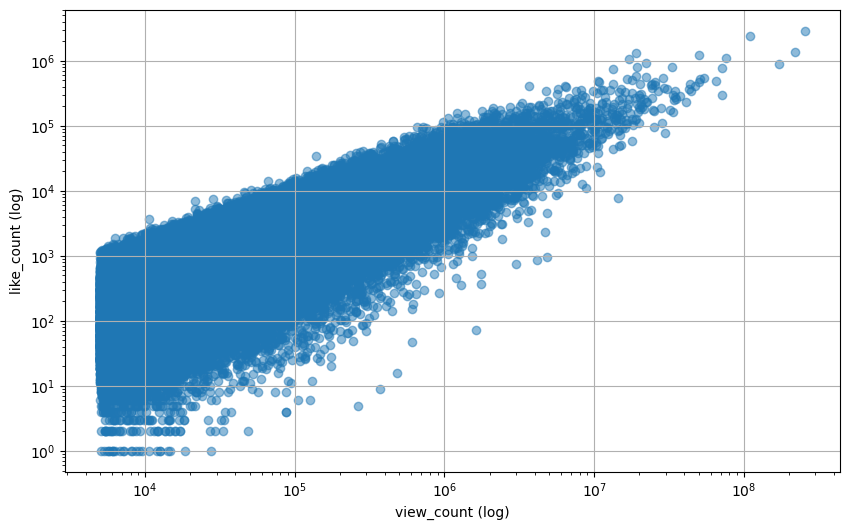

In [4]:
filename2 = f"df_channels_en.tsv.gz"
channels = pd.read_csv("df_channels_en.tsv.gz", compression='gzip', sep='\t')

# We want to take the number of subscribers into account.

df = pd.merge(df, channels[['channel', 'subscribers_cc']], left_on='channel_id', right_on='channel', how='left')
df.drop(columns='channel', inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(df['view_count'], df['like_count'], alpha=0.5)
plt.xlabel('view_count (log)')
plt.ylabel('like_count (log)')
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.show()

#### The above figure is a log-log scatter plot of likes versus views. From the graph, we can infer that the number of likes is generally positively correlated with the number of views.
 #### We plan to perform a linear regression on the like count using the remaining factors, assessing the impact of each factor on the like count based on their weights.

In [5]:
original_df = df.copy()

# Normalize the quatitative variables
df['dislike_count'] = (df['dislike_count'] - df['dislike_count'].mean())/df['dislike_count'].std()
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()
df['view_count'] = (df['view_count'] - df['view_count'].mean())/df['view_count'].std()
df['subscribers_cc'] = (df['subscribers_cc'] - df['subscribers_cc'].mean())/df['subscribers_cc'].std()


mod = smf.ols(formula='like_count ~ dislike_count + duration + view_count + subscribers_cc + C(entertainment) + C(conspiracy)',
              data=df)

result = mod.fit()

print(result.summary())
highest_coefficient = result.params.abs().nlargest(5)
print(highest_coefficient)

                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                 7.130e+04
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:11:26   Log-Likelihood:            -2.1798e+06
No. Observations:              208149   AIC:                         4.360e+06
Df Residuals:                  208142   BIC:                         4.360e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2252.48

#### We can see that after normalization, the positive impact of views on the like count is the largest. At the same time, whether the video is categorized as entertainment and whether it contains conspiracy theory keywords in the title or tags also have a significant positive impact on the like count. It can be seen from the p-value that the influence of these factors is significant.

#### Furthermore, we will explore the interaction between the factors of whether a video is categorized as entertainment and whether it contains conspiracy theory keywords in the title or tags.  We will introduce the interaction term of the two factors to perform linear regression.


In [6]:
mod2 = smf.ols(formula='like_count ~ dislike_count + duration + view_count + subscribers_cc + C(entertainment) * C(conspiracy)',
              data=df)

result2 = mod2.fit()

print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                 6.112e+04
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:12:14   Log-Likelihood:            -2.1798e+06
No. Observations:              208149   AIC:                         4.360e+06
Df Residuals:                  208141   BIC:                         4.360e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

#### Surprisingly, the coefficient of the interaction term between the two is actually negative. This means that, all else being equal, if a video is an entertainment video with conspiracy-related keywords in its title or tags, it tends to have fewer likes than entertainment videos without conspiracy keywords or non-entertainment videos with conspiracy keywords. However, the p-value of the interaction term is greater than 0.05, so this effect may not be significant.

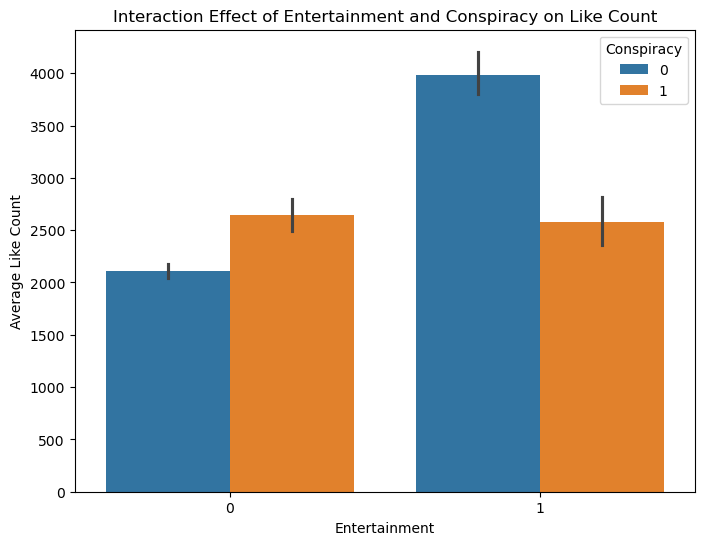

In [7]:
df['entertainment'] = df['entertainment'].astype('category')
df['conspiracy'] = df['conspiracy'].astype('category')


plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='entertainment', y='like_count', hue='conspiracy', errorbar='ci')


plt.title('Interaction Effect of Entertainment and Conspiracy on Like Count')
plt.xlabel('Entertainment')
plt.ylabel('Average Like Count')
plt.legend(title='Conspiracy')
plt.show()

####  In the figure, we can see that the average number of likes for entertainment videos with conspiracy-related keywords in the title or tags is lower than that of entertainment videos without conspiracy keywords, as well as lower than that of non-entertainment videos with conspiracy keywords.

#### However, this analysis is very naive because entertainment videos without conspiracy keywords may have a much larger sample size than those with conspiracy-related keywords, and the view count for videos without conspiracy keywords may be higher than that for videos with conspiracy-related keywords, leading to this phenomenon. Therefore, we hope to balance the data to verify whether the number of likes for entertainment videos without conspiracy keywords is significantly greater than that for entertainment videos with conspiracy-related keywords in the title or tags.
 

In [8]:
entertainment = original_df.copy()
entertainment = entertainment[entertainment['entertainment'] == 1]
entertainment.drop(columns='entertainment', inplace=True)


#### We can see that the average view count for entertainment videos without conspiracy keywords is nearly five times that of entertainment videos with conspiracy-related keywords in the title or tags. This may be due to the presence of more extreme values in the sample of entertainment videos without conspiracy keywords.

#### First, we calculate the propensity score to balance the data.

In [9]:
# Standardize the features
entertainment['dislike_count'] = (entertainment['dislike_count'] - entertainment['dislike_count'].mean())/entertainment['dislike_count'].std()
entertainment['duration'] = (entertainment['duration'] - entertainment['duration'].mean())/entertainment['duration'].std()
entertainment['view_count'] = (entertainment['view_count'] - entertainment['view_count'].mean())/entertainment['view_count'].std()
entertainment['subscribers_cc'] = (entertainment['subscribers_cc'] - entertainment['subscribers_cc'].mean())/entertainment['subscribers_cc'].std()


mod = smf.logit(formula='conspiracy ~ dislike_count + duration + view_count + subscribers_cc', data=entertainment)

res = mod.fit()

# Extract the estimated propensity scores
entertainment['Propensity_score_conspiracy'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.084376
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             conspiracy   No. Observations:                28671
Model:                          Logit   Df Residuals:                    28666
Method:                           MLE   Df Model:                            4
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                 0.06825
Time:                        23:13:52   Log-Likelihood:                -2419.2
converged:                       True   LL-Null:                       -2596.4
Covariance Type:            nonrobust   LLR p-value:                 1.943e-75
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.4976      0.169    -32.504      0.000      -5.829      -5.166
dislike_count   

/Users/zts/opt/anaconda3/envs/Ada/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/zts/opt/anaconda3/envs/Ada/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


#### Due to the high computational complexity of matching the data, we will sample the data first.

In [12]:
conspiracy = entertainment[entertainment['conspiracy'] == 1]
non_conspiracy = entertainment[entertainment['conspiracy'] == 0]

conspiracy_sample = conspiracy.sample(frac=0.57, random_state=42) 
non_conspiracy_sample = non_conspiracy.sample(frac=0.011, random_state=42)

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

import networkx as nx

# Create an empty undirected graph
G = nx.Graph()
i = 0
# Loop through all the pairs of instances
for control_id, control_row in non_conspiracy_sample.iterrows():
    for treatment_id, treatment_row in conspiracy_sample.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score_conspiracy'],
                                    treatment_row['Propensity_score_conspiracy'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

        

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

# Create a list of matched indices
matched = []
for pair in matching:
    matched.append(pair[0])  # Control group index
    matched.append(pair[1])  # Treatment group index

# Create balanced DataFrame using original indices
balanced_df_conspiracy = original_df.loc[original_df.index.isin(matched)]

conspiracy = balanced_df_conspiracy.loc[balanced_df_conspiracy['conspiracy'] == 1]
non_conspiracy = balanced_df_conspiracy.loc[balanced_df_conspiracy['conspiracy'] == 0]

In [14]:
conspiracy.like_count.describe()

count      519.000000
mean      2581.579961
std       2647.678449
min         15.000000
25%        824.500000
50%       1692.000000
75%       3861.000000
max      23551.000000
Name: like_count, dtype: float64

In [15]:
non_conspiracy.like_count.describe()

count    2.815200e+04
mean     3.984024e+03
std      1.689000e+04
min      0.000000e+00
25%      4.770000e+02
50%      1.112000e+03
75%      2.498000e+03
max      1.235449e+06
Name: like_count, dtype: float64

#### In the balanced data, the average view count for entertainment videos with conspiracy keywords is lower than the average like count for entertainment videos with conspiracy-related keywords in the title or tags.

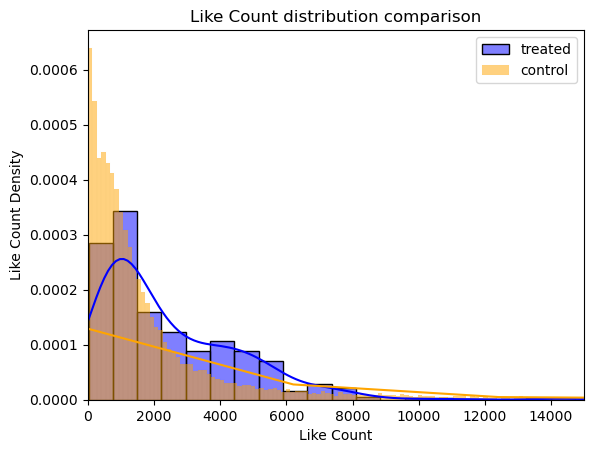

In [13]:
ax = sns.histplot(conspiracy['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(non_conspiracy['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count Density')
# plt.xscale('log')
plt.xlim(0,15000)
plt.legend()
plt.show()

In [16]:
statistic, p_value = stats.mannwhitneyu(conspiracy['like_count'], non_conspiracy['like_count'], alternative='greater')

print(f"U statistic: {statistic}, p-value: {p_value}")

# Therefore, it can be considered that the median of the conspiracy theory group is significantly larger than the median of the non-conspiracy theory group on like_count.

U statistic: 8819503.5, p-value: 2.6726670339288943e-16


In [17]:
# Average Treatment Effect

ATE = conspiracy['like_count'].mean() - non_conspiracy['like_count'].mean()
print(F"ATE: {ATE}")

ATE: -1402.444264167927
